### Variational Autoencoders


The encoding is somewhat obvious, transformation into another representation. Decoding inverses the encoding. The **autoencoder** is a Neural Network trained to perform encoding and decoding. It's generative because it can interpolate, in between existing data points.

In [82]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from utils import display

(x_train, y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

# we need to scale the pixel values (0-255) to (0-1) and pad (to go from 28x28 to 32x32)
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test  = preprocess(x_test)
print("x_train size is ", x_train.shape)
print("x_test size is  ", x_test.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x_train size is  (60000, 32, 32, 1)
x_test size is   (10000, 32, 32, 1)


An autoencoder neural network is comprised of two parts:
* An encoder that compresses high-demiensional data (like an image) into a lower-dimensional embedding vector.
* A decoder that decompresses the vecotr back to original domain.

The lower-dimensional represenation is often called **latent space**.

Let's start building the autoencoder, first **The Encoder**.


In [83]:

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
print("encoder_input shape is ",encoder_input.shape)
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
) 
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
print("The shape before flattening is ", shape_before_flattening)

x = layers.Flatten()(x)
print("x shape is ",x.shape)

encoder_output = layers.Dense(EMBEDDING_DIM,name="encoder_output")(x)
print("encoder_output shape is ", encoder_output.shape)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

encoder_input shape is  (None, 32, 32, 1)
The shape before flattening is  (4, 4, 128)
x shape is  (None, 2048)
encoder_output shape is  (None, 2)
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)      

Going further? Experimenting with number of convolution layers and filters to understand
how the architecture affects the overall number of model parameters and performance.

### Decoder 
Time to build the decoder, which is the mirror image of the encoder.... 

In [84]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input") 
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) 
x = layers.Reshape(shape_before_flattening)(x) 
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x) 
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output) 
decoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 8, 8, 128)         147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_16 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 32, 32, 32)        184

In [85]:
# Join the encoder and decoder to create the autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_22 (Functional)       (None, 32, 32, 1)         246

In [86]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2919INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 29s 47ms/step - loss: 0.2919 - val_loss: 0.2607
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2572INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 27s 45ms/step - loss: 0.2572 - val_loss: 0.2561
Epoch 3/3
599/600 [============================>.] - ETA: 0s - loss: 0.2538INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 26s 43ms/step - loss: 0.2538 - val_loss: 0.2555


In [87]:
# save the models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


157/157 [==============================] - 1s 8ms/step
Example real clothing items


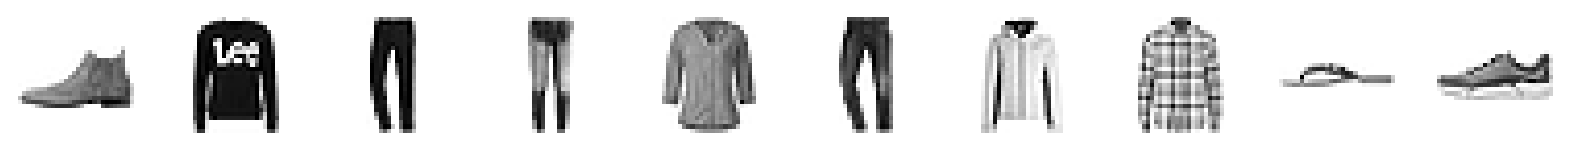

Reconstructions


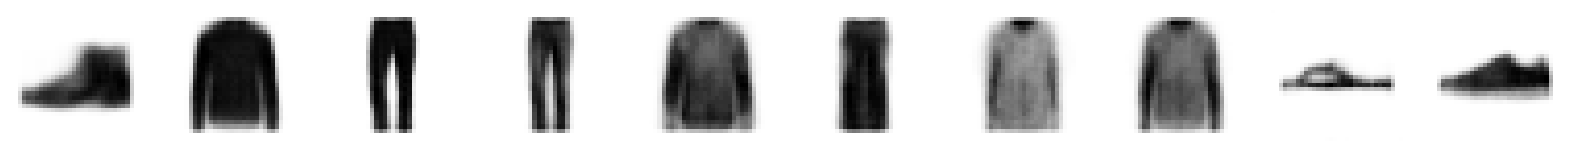

In [88]:
# Reconstructing the images using the autoencoder
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)


### Visualizing the latent space


In [89]:
embeddings = encoder.predict(example_images)

# Some examples of the embeddings
print(embeddings[:10])



157/157 [==============================] - 1s 9ms/step
[[[[8.05953387e-05]
   [3.88265562e-06]
   [8.11062000e-06]
   ...
   [4.74191984e-06]
   [3.37824372e-06]
   [1.65469508e-04]]

  [[3.62445712e-06]
   [2.26649675e-07]
   [8.16129443e-07]
   ...
   [7.08283039e-07]
   [2.98063469e-07]
   [4.51308042e-05]]

  [[7.68782138e-06]
   [7.20742378e-07]
   [1.13795186e-05]
   ...
   [1.80529569e-05]
   [5.16539012e-06]
   [1.17920557e-04]]

  ...

  [[2.65136055e-06]
   [3.31938793e-07]
   [4.95595214e-06]
   ...
   [4.02171423e-07]
   [7.35895540e-08]
   [8.83342364e-06]]

  [[6.14531109e-06]
   [4.34828138e-07]
   [5.16023510e-06]
   ...
   [1.55099457e-07]
   [5.91438400e-08]
   [5.79926518e-06]]

  [[2.69399781e-04]
   [6.17148326e-05]
   [1.82536911e-04]
   ...
   [1.28622642e-05]
   [6.13292332e-06]
   [3.46106273e-04]]]


 [[[9.21283405e-09]
   [2.46708244e-11]
   [9.32883909e-11]
   ...
   [4.72246409e-10]
   [6.07193115e-11]
   [7.58877476e-08]]

  [[8.91980864e-11]
   [7.0487973

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]
print("example labels size is ", example_labels.shape)

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    # c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## Generate Images using the decoder

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

print("mins shape is ", mins.shape)
print("maxs shape is ", maxs.shape)

# Sample some points in the latent space
grid_width, grid_height = (8, 4)
print("size will be computed as %d by %d" % (grid_height * grid_width, EMBEDDING_DIM))

sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, grid_width * grid_height, EMBEDDING_DIM)
)

# Decode the sampled points
reconstructions = decoder.predict(sample)

